In [100]:
%%capture
BASEPATH = '../'
import sys
sys.path.insert(0,'..')

import numpy as np
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from pyecg.utils import reset_seed, plot_spectogram, plot_loss, load_data
from pyecg.utils import integer_mapping, mapping_AAMI, calc_class_weights
from pyecg.data_info import *
from pyecg.data_preprocessing import clean_inf_nan,clean_IQR,clean_IQR_class
from pyecg.data_handling import DataHandling,slice_data
from pyecg.report import Reports
from pyecg.utils import sig_similarity_report,sig_similarity_hist



reset_seed() 

# Proto

In [101]:
datasets = {1:'raw',2:'stft'}
models = {1:'conv1d', 2:'conv2d', 3:'anomaly_fcn',
          4:'anomaly_conv1d',5:'anomaly_conv2d',
          6:'beat_model',7:'beat_conv1d_rri_paral'}

CONFIG = {}
CONFIG['dataset'] = datasets[1]
CONFIG['model'] = models[7]
CONFIG['model_type'] = 'CLF' #CLF or AE
CONFIG['augment'] = False 
CONFIG['sliced_targets'] = None #{'N':0,'A':1,'V':2} #None  #{'N':0,'A':1}
CONFIG['AAMI'] = False 
CONFIG['class_weight'] = False 
CONFIG['normalization'] = None       #'zscore' 'minmax' , None, 'max' 

# Data

In [107]:
#Load data
dh = DataHandling(base_path='../data')

if CONFIG['dataset'] == 'raw':
    ds_train = dh.load_data(file_name = 'train.beat')
    x_train, r_train, y_train = ds_train.values()
    
    ds_val = dh.load_data(file_name = 'val.beat')
    x_val, r_val, y_val = ds_val.values()

elif CONFIG['dataset'] == 'stft':
    ds_train = dh.load_data(file_path = '../data/DS1_train_stft.dat')
    x_train, y_train, r_train = ds_train.values()
    ds_val = load_data(file_path = '../data/DS1_val_stft.dat')
    x_val, y_val, r_val = ds_val.values()


file loaded: ../data/train.beat
shape of "waveforms" is (27090, 800)
shape of "beat_feats" is (27090, 2)
shape of "labels" is (27090,)
                N     L     R   j   e     V    E    A  S   a   J    F  f  /  Q
train.beat  20200  1457  1592  14  16  2482  105  684  2  98  30  404  0  0  6
file loaded: ../data/val.beat
shape of "waveforms" is (23491, 800)
shape of "beat_feats" is (23491, 2)
shape of "labels" is (23491,)
              N     L     R  j  e     V  E    A  S  a  J  F  f  /  Q
val.beat  17562  2473  2149  1  0  1181  0  113  0  0  2  8  0  0  2


In [108]:
ds_train = clean_inf_nan(ds_train)
x_train, r_train, y_train = ds_train.values()

In [109]:
xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx) 

(3.0571681682263936, -3.531306100843774, 0.05353817446333654)

In [110]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(84.32786885245812, 0.2768924302789901, 1.0125611883700758)

<AxesSubplot:>

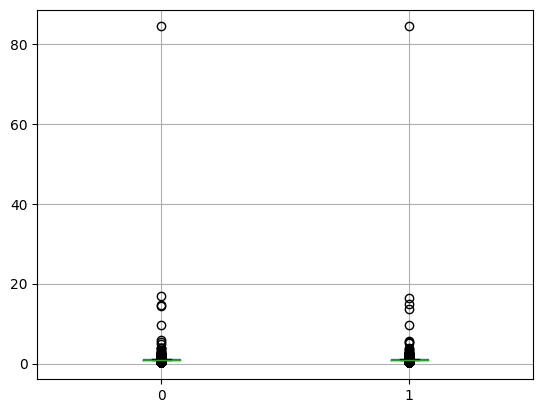

In [111]:
r_train.shape
pd.DataFrame(r_train).boxplot()

In [112]:
list(np.unique(y_train))

['A', 'E', 'F', 'J', 'L', 'N', 'Q', 'R', 'S', 'V', 'a', 'e', 'j']

In [113]:
x_train, r_train, y_train = ds_train.values()
r_train.shape

(27090, 2)

<AxesSubplot:>

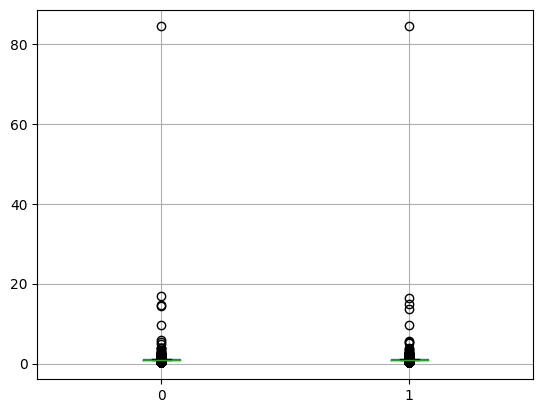

In [114]:
pd.DataFrame(r_train).boxplot()

In [115]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(84.32786885245812, 0.2768924302789901, 1.0125611883700758)

In [116]:
ix = dh.search_label(ds_train,'N')

In [117]:
rp1 = dh.report_stats_table([y_train, y_val], ['train','val'])
rp1 

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
train,20200,1457,1592,14,16,2482,105,684,2,98,30,404,0,0,6
val,17562,2473,2149,1,0,1181,0,113,0,0,2,8,0,0,2


In [118]:
#slice data
if CONFIG['sliced_targets'] is not None:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_train = slice_data(ds_train, sliced_targets)
    x_train, r_train, y_train = ds_train.values()
    ds_val = slice_data(ds_val, sliced_targets)
    x_val, r_val, y_val = ds_val.values()
    rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
    print(rp2)

In [119]:
#Normalization
if CONFIG['normalization'] == 'zscore':
    from sklearn.preprocessing import StandardScaler
    standardscaler_x = StandardScaler()
    x_train = standardscaler_x.fit_transform(x_train)
    x_val = standardscaler_x.transform(x_val) 
    
    standardscaler_r = StandardScaler()
    r_train = standardscaler_r.fit_transform(r_train)
    r_val = standardscaler_r.transform(r_val) 

if CONFIG['normalization'] == 'minmax':
    from sklearn.preprocessing import MinMaxScaler
    scaler_x = MinMaxScaler(feature_range=(-1,1)) 
    if len(x_train[0].shape)==1:
        x_train = scaler_x.fit_transform(x_train)
        x_val = scaler_x.transform(x_val)
    elif len(x_train[0].shape)==2:
        org_shape = x_train.shape
        x_train = scaler_x.fit_transform(x_train.reshape((-1,1)))
        x_train = x_train.reshape(org_shape)
        org_shape = x_val.shape
        x_val = scaler_x.transform(x_val.reshape((-1,1)))
        x_val = x_val.reshape(org_shape)

    scaler_r = MinMaxScaler(feature_range=(-1,1))
    r_train = scaler_r.fit_transform(r_train)
    r_val = scaler_r.transform(r_val)   

if CONFIG['normalization'] == 'max':   
    max_x_train = max(x_train.flatten())
    x_train = x_train/max_x_train
    x_val = x_val/max_x_train

xx =  x_train.flatten()
max(xx),min(xx),sum(xx)/len(xx)

(3.0571681682263936, -3.531306100843774, 0.05353817446333654)

In [120]:
rr =  r_train.flatten()
max(rr),min(rr),sum(rr)/len(rr) 

(84.32786885245812, 0.2768924302789901, 1.0125611883700758)

<AxesSubplot:>

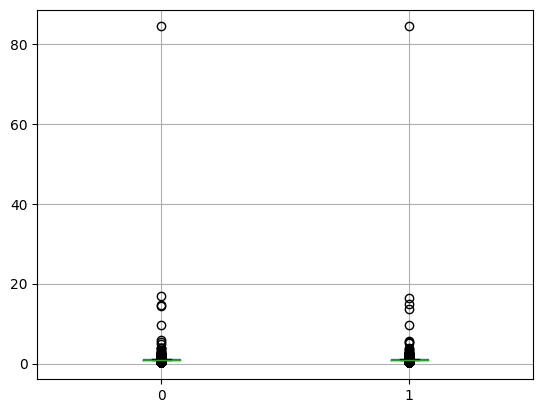

In [121]:
#normalized
pd.DataFrame(r_train).boxplot()

In [122]:
if CONFIG['AAMI']:
    y_train = mapping_AAMI(y_train, MAP_AAMI)
    y_val = mapping_AAMI(y_val, MAP_AAMI)

In [123]:
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2) 

           N     L     R   j   e     V    E    A  S   a   J    F  f  /  Q
train  20200  1457  1592  14  16  2482  105  684  2  98  30  404  0  0  6
val    17562  2473  2149   1   0  1181    0  113  0   0   2    8  0  0  2


In [124]:
#augment
if CONFIG['augment']==True:
    from pyecg.data_augmentation import aug_decrease,aug_increase
    ds_train = aug_decrease(ds_train, label='N', desired_size = 12000)
    ds_train = aug_increase(ds_train, desired_size = 12000)
    x_train, r_train, y_train = ds_train.values()
    
rp2 = dh.report_stats_table([y_train, y_val], ['train','val'])
print(rp2)

           N     L     R   j   e     V    E    A  S   a   J    F  f  /  Q
train  20200  1457  1592  14  16  2482  105  684  2  98  30  404  0  0  6
val    17562  2473  2149   1   0  1181    0  113  0   0   2    8  0  0  2


In [125]:
#convert labels to integers
targets = np.unique(y_train).tolist()
FINAL_MAP_DICT = {targets[i]:i for i in range(len(targets))}


y_train = integer_mapping(y_train, FINAL_MAP_DICT)
y_val = integer_mapping(y_val, FINAL_MAP_DICT)

In [126]:
np.unique(y_train), r_train.shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]), (27090, 2))

# Train

In [127]:
if CONFIG['model'] == 'conv2d':
    from pyecg.models.conv2d_rr import model_arch
elif CONFIG['model'] == 'conv1d':
    from pyecg.models.beat_conv1D import model_arch
elif CONFIG['model'] == 'anomaly_fcn':
    from pyecg.models.anomaly_FCN import model_arch
elif CONFIG['model'] == 'anomaly_conv1d':
    from pyecg.models.anomaly_conv1d import model_arch
elif CONFIG['model'] == 'anomaly_conv2d':
    from pyecg.models.anomaly_conv2d import model_arch
elif CONFIG['model'] == 'beat_model':
    from pyecg.models.beat_model import model_arch
elif CONFIG['model'] == 'beat_conv1d_rri_paral':
    from pyecg.models.beat_conv1d_rri_paral import model_arch   

In [128]:
params_model = {
    'x_input_dim' : np.squeeze(x_train[0].shape),
    'r_input_dim':r_train.shape[-1],
    'num_classes' : len(np.unique(y_train)),
    'dim_latent' : 10,
    'regularizer' : None
}
params_train = {
    'batch_size' : 128,
    'epochs' : 4
} 

In [129]:
params_model

{'x_input_dim': array(800),
 'r_input_dim': 2,
 'num_classes': 13,
 'dim_latent': 10,
 'regularizer': None}

In [130]:
mymodel = model_arch(params_model)   
mymodel.summary()

block1:

Layer: FLATTEN_10/RESHAPE:0 -->  Output shape: [None, 368]
block2:

Layer: FLATTEN_11/RESHAPE:0 -->  Output shape: [None, 384]
block3:

Layer: FLATTEN_12/RESHAPE:0 -->  Output shape: [None, 392]
block4:

Layer: FLATTEN_13/RESHAPE:0 -->  Output shape: [None, 396]
block5:

Layer: FLATTEN_14/RESHAPE:0 -->  Output shape: [None, 398]

Layer: DROPOUT_21/IDENTITY:0 -->  Output shape: [None, 1938]

Layer: DROPOUT_22/IDENTITY:0 -->  Output shape: [None, 512]

Layer: DROPOUT_23/IDENTITY:0 -->  Output shape: [None, 12]
Model: "Model_Conv1d_RR"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x_input (InputLayer)           [(None, 800)]        0           []                               
                                                                                                  
 tf.expand_dims_2 (TFOpLambda)  (None, 800, 1)       0  

 flatten_14 (Flatten)           (None, 398)          0           ['max_pooling1d_14[0][0]']       
                                                                                                  
 concatenate_4 (Concatenate)    (None, 1938)         0           ['flatten_10[0][0]',             
                                                                  'flatten_11[0][0]',             
                                                                  'flatten_12[0][0]',             
                                                                  'flatten_13[0][0]',             
                                                                  'flatten_14[0][0]']             
                                                                                                  
 dropout_21 (Dropout)           (None, 1938)         0           ['concatenate_4[0][0]']          
                                                                                                  
 dense_6 (

In [131]:
#%%capture
#!pip install focal-loss
#from focal_loss import SparseCategoricalFocalLoss

In [132]:
def my_log_loss(y_true, y_pred):
    squared_difference = tf.square(tf.math.log(y_true + 5) - tf.math.log(y_pred + 5))
    return tf.reduce_mean(squared_difference, axis=-1) 

In [133]:
!rm -r /media/ubuntu/usbdata/ecg/checkpoint/keras.BEST

opt= tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adam')
#opt = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)

def get_loss(model_type):
    if model_type == 'AE':
        loss = "mse"
        #loss = 'binary_crossentropy'
        #loss='mean_squared_logarithmic_error'
        #loss = my_log_loss
        #loss = 'cosine_similarity'
    elif model_type == 'CLF':
        loss = "sparse_categorical_crossentropy"
        #loss=SparseCategoricalFocalLoss(gamma=3)
    return loss

def get_metrics(model_type):
    if model_type == 'AE':
        metrics = None
    elif model_type == 'CLF':
        metrics = ['accuracy']
    return metrics
    

mymodel.compile(
              optimizer = opt,
              loss = get_loss(CONFIG['model_type']),
              metrics = get_metrics(CONFIG['model_type']),
              loss_weights = None
              )


early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=8, verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=5,
                              verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0.0001)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(BASEPATH + "checkpoint/keras.BEST",
                                                      monitor='val_loss', save_best_only=True, verbose=1)
import time
batch_sleep = tf.keras.callbacks.LambdaCallback(on_batch_end=lambda batch,logs: time.sleep(.3))

callbacks = [early_stopping, model_checkpoint, reduce_lr, batch_sleep]  
#callbacks = [batch_sleep]  

In [134]:
calc_class_weights(CONFIG['class_weight'], y_train)

In [135]:
#model output
if CONFIG['model_type'] == 'AE':
    output_shape = mymodel.output_shape
    if isinstance(output_shape,list) and len(output_shape) == 2:
        y_train_ = [x_train,r_train]
        y_val_ = [x_val,r_val]   
    elif not isinstance(output_shape,list):
        y_train_ = x_train
        y_val_ = x_val 
else:
    y_train_ = y_train 
    y_val_ = y_val 

#model input   
input_shape = mymodel.input_shape
if isinstance(input_shape,list) and len(input_shape) == 2:
    x_train_ = {'x_input':x_train, 'r_input':r_train}
    x_val_ = {'x_input':x_val, 'r_input':r_val}   
elif not isinstance(input_shape,list): 
    x_train_ = x_train
    x_val_ = x_val    
    

In [136]:
%%time

#model fitting
model_history = mymodel.fit(
              x=x_train_,
              y=y_train_,
              batch_size=params_train['batch_size'],
              epochs=params_train['epochs'],
              verbose=1,
              callbacks=callbacks,
              validation_data=(x_val_, y_val_),
              shuffle=True,
              class_weight= calc_class_weights(CONFIG['class_weight'], y_train),    #None,
              sample_weight=None,
              initial_epoch=0
              )

Epoch 1/4
212/212 [==============================] - ETA: 0s - loss: 0.8188 - accuracy: 0.7594
Epoch 1: val_loss improved from inf to 1.44480, saving model to ../checkpoint/keras.BEST


212/212 [==============================] - 124s 567ms/step - loss: 0.8188 - accuracy: 0.7594 - val_loss: 1.4448 - val_accuracy: 0.6947 - lr: 0.0010
Epoch 2/4
212/212 [==============================] - ETA: 0s - loss: 0.3993 - accuracy: 0.8865
Epoch 2: val_loss did not improve from 1.44480
212/212 [==============================] - 114s 539ms/step - loss: 0.3993 - accuracy: 0.8865 - val_loss: 1.6558 - val_accuracy: 0.7078 - lr: 0.0010
Epoch 3/4
212/212 [==============================] - ETA: 0s - loss: 0.2686 - accuracy: 0.9222
Epoch 3: val_loss did not improve from 1.44480
212/212 [==============================] - 113s 534ms/step - loss: 0.2686 - accuracy: 0.9222 - val_loss: 1.4728 - val_accuracy: 0.7090 - lr: 0.0010
Epoch 4/4
212/212 [==============================] - ETA: 0s - loss: 0.2297 - accuracy: 0.9313
Epoch 4: val_loss improved from 1.44480 to 1.41167, saving model to ../checkpoint/keras.BEST


212/212 [==============================] - 118s 558ms/step - loss: 0.2297 - accuracy: 0.9313 - val_loss: 1.4117 - val_accuracy: 0.7236 - lr: 0.0010
CPU times: user 11min 7s, sys: 18.9 s, total: 11min 26s
Wall time: 7min 50s


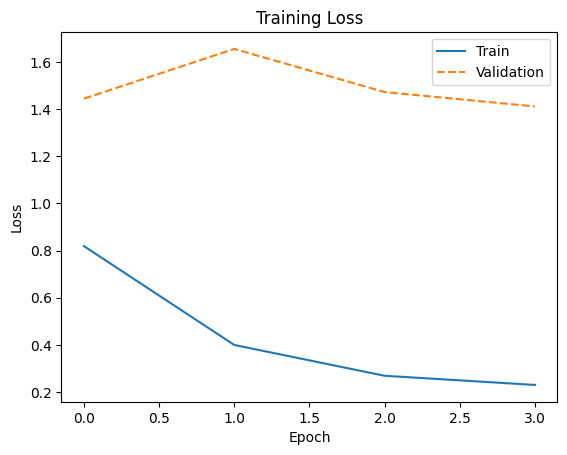

In [138]:
plot_loss(model_history) 

import pickle
with open(BASEPATH+'history/EXP1.hist', 'wb') as f:
  pickle.dump(model_history.history, f)

a =model_history.history
min(a['val_loss']), a['val_loss'].index(min(a['val_loss']))

# Loading Model

In [150]:
loaded_model = tf.keras.models.load_model(BASEPATH+'checkpoint/keras.BEST')
#mymodel = tf.keras.models.load_model(BASEPATH+'saved_models/mymodel')
#loaded_model = mymodel
loaded_model.name
#loaded_model.summary()

'Model_Conv1d_RR'

In [151]:
#Load Preprocessed Test Set
dh = DataHandling(base_path='../data')
if CONFIG['dataset'] == 'raw':
    ds_test = dh.load_data(file_name = 'test.beat')
    ds_test = clean_inf_nan(ds_test)
    x_test, r_test, y_test = ds_test.values()   
    
elif CONFIG['dataset'] == 'stft':
    ds_test = dh.load_data(file_name = 'DS2_stft.dat')
    x_test, y_test, r_test = ds_test.values() 

file loaded: ../data/test.beat
shape of "waveforms" is (49272, 800)
shape of "beat_feats" is (49272, 2)
shape of "labels" is (49272,)
               N     L     R    j  e     V  E     A  S   a   J    F  f  /  Q
test.beat  36118  4089  3441  213  0  3194  1  1720  0  50  51  388  0  0  7


In [152]:
#slice test data
if CONFIG['sliced_targets'] != None and params_model['num_classes']>1:
    from pyecg.data_handling import slice_data
    sliced_targets = CONFIG['sliced_targets']
    ds_test = slice_data(ds_test, sliced_targets)
    x_test, r_test, y_test = ds_test.values() 

In [153]:
rp2 = dh.report_stats_table([y_test], ['test'])
rp2

,N,L,R,j,e,V,E,A,S,a,J,F,f,/,Q
test,36118,4089,3441,213,0,3194,1,1720,0,50,51,388,0,0,7


In [154]:
y_true = y_test.copy()

if CONFIG['AAMI']:
    y_true = mapping_AAMI(y_true, MAP_AAMI)

In [155]:
if CONFIG['normalization'] == 'zscore':
    x_test = standardscaler_x.transform(x_test) 
    r_test = standardscaler_r.transform(r_test) 

if CONFIG['normalization'] == 'minmax':
    x_test = scaler_x.transform(x_test)
    r_test = scaler_r.transform(r_test)
    
if CONFIG['normalization'] == 'max':   
    x_test = x_test/max_x_train

In [156]:
if isinstance(input_shape,list) and len(input_shape) == 2:
    x_test = {'x_input':x_test, 'r_input':r_test}
    

In [157]:
%%time
y_pred_p = loaded_model.predict(x_test)
y_pred_p.shape

2022-06-03 16:44:01.462251: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 157670400 exceeds 10% of free system memory.


1540/1540 [==============================] - 25s 16ms/step
CPU times: user 1min 4s, sys: 1.41 s, total: 1min 5s
Wall time: 25.7 s


(49272, 13)

In [158]:
def apply_uncertainty(probabilities, true, thr = 0.98):
    prop_max = np.max(probabilities,axis=1)
    probs = probabilities[np.where(prop_max>thr)[0]]
    y_true = true[np.where(prop_max>thr)[0]]
    return probs,y_true

In [159]:
if CONFIG['model_type'] == 'CLF':
    y_pred = integer_mapping(list(y_pred_p.argmax(axis=-1)), FINAL_MAP_DICT, inverse=True)
    dh = DataHandling() 
    rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
    print(rp2)
    labels = [k for k,v in INT_MAP_DICT.items()]
    report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
    normalize = None
    #report.plot_confusion_matrix(normalize=normalize, values_format='')
    print(report.the_classification_report())
    #report.metrics_table() 
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_true, y_pred)) 

            N     L     R    j  e     V    E     A  S   a   J    F  f  /  Q
y_pred  43509     1   316    0  0  4952  131   230  0   0   0  133  0  0  0
y_true  36118  4089  3441  213  0  3194    1  1720  0  50  51  388  0  0  7


/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           A     0.1348    0.0180    0.0318      1720
           E     0.0000    0.0000    0.0000         1
           F     0.5714    0.1959    0.2917       388
           J     0.0000    0.0000    0.0000        51
           L     0.0000    0.0000    0.0000      4089
           N     0.7840    0.9444    0.8567     36118
           Q     0.0000    0.0000    0.0000         7
           R     0.0475    0.0044    0.0080      3441
           V     0.5810    0.9008    0.7064      3194
           a     0.0000    0.0000    0.0000        50
           j     0.0000    0.0000    0.0000       213

    accuracy                         0.7531     49272
   macro avg     0.1926    0.1876    0.1722     49272
weighted avg     0.6249    0.7531    0.6778     49272

[[   31     0     0     0     0  1669     0     0    20     0     0]
 [    0     0     0     0     0     1     0     0     0     0     0]
 [    0     0    76     0     0   270     0     0

In [160]:
if CONFIG['model_type'] == 'CLF':
    #apply uncertainty
    y_pred_p, y_true = apply_uncertainty(y_pred_p,y_true, thr = 0.99)
    
    y_pred = integer_mapping(list(y_pred_p.argmax(axis=-1)), FINAL_MAP_DICT, inverse=True)
    dh = DataHandling() 
    rp2 = dh.report_stats_table([y_pred, y_true], ['y_pred','y_true'])
    print(rp2)
    labels = [k for k,v in INT_MAP_DICT.items()]
    report = Reports(y_true=y_true, y_pred=y_pred, labels=labels)
    normalize = None
    #report.plot_confusion_matrix(normalize=normalize, values_format='')
    print(report.the_classification_report())
    #report.metrics_table() 
    from sklearn.metrics import confusion_matrix, classification_report
    print(confusion_matrix(y_true, y_pred)) 

            N    L     R   j  e     V  E   A  S  a   J   F  f  /  Q
y_pred  18192    0     0   0  0  1571  0   0  0  0   0   0  0  0  0
y_true  15827  531  1713  14  0  1588  1  37  0  2  11  35  0  0  4
              precision    recall  f1-score   support

           A     0.0000    0.0000    0.0000        37
           E     0.0000    0.0000    0.0000         1
           F     0.0000    0.0000    0.0000        35
           J     0.0000    0.0000    0.0000        11
           L     0.0000    0.0000    0.0000       531
           N     0.8696    0.9996    0.9301     15827
           Q     0.0000    0.0000    0.0000         4
           R     0.0000    0.0000    0.0000      1713
           V     0.9936    0.9830    0.9883      1588
           a     0.0000    0.0000    0.0000         2
           j     0.0000    0.0000    0.0000        14

    accuracy                         0.8795     19763
   macro avg     0.1694    0.1802    0.1744     19763
weighted avg     0.7763    0.8795    0

/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/media/ubuntu/usbdata/ecg/ecgenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [92]:
FINAL_MAP_DICT

{'A': 0,
 'F': 1,
 'J': 2,
 'L': 3,
 'N': 4,
 'Q': 5,
 'R': 6,
 'S': 7,
 'V': 8,
 'a': 9,
 'e': 10,
 'j': 11}

In [93]:
#uncertainty
from pyecg.data_handling import slice_data
sliced_targets = {'A':0}
ds_test_c = slice_data(ds_test, sliced_targets)
x_test, r_test, y_test = ds_test_c.values()
if isinstance(input_shape,list) and len(input_shape) == 2:
    x_test = {'x_input':x_test, 'r_input':r_test}
y_pred_p = loaded_model.predict(x_test)
y_pred_p

8/8 [==============================] - 0s 12ms/step


array([[2.9631322e-03, 3.8409428e-04, 1.6792435e-03, ..., 2.1111974e-04,
        6.9163673e-07, 1.2419335e-05],
       [7.9539955e-02, 3.3953149e-02, 7.8643724e-02, ..., 4.8527386e-02,
        6.7490581e-03, 9.7260186e-03],
       [4.7626399e-02, 2.5371868e-02, 7.2344825e-02, ..., 2.9505324e-02,
        7.2534783e-03, 1.0670590e-02],
       ...,
       [7.3895186e-02, 4.0490884e-02, 7.3230170e-02, ..., 4.4945680e-02,
        8.9346031e-03, 1.2000818e-02],
       [6.4469799e-02, 2.7226204e-02, 4.8375651e-02, ..., 2.6413709e-02,
        2.3066287e-03, 4.9149692e-03],
       [5.1018585e-02, 1.7277660e-02, 3.2758687e-02, ..., 1.6374908e-02,
        7.9654146e-04, 2.3008040e-03]], dtype=float32)

In [94]:
y_pred_p.shape

(250, 12)

In [95]:
prop_max = np.max(y_pred_p,axis=1)

(array([ 2., 10., 14., 26., 90., 17., 15., 16., 20., 40.]),
 array([0.27363515, 0.34621915, 0.4188032 , 0.4913872 , 0.5639712 ,
        0.6365552 , 0.7091392 , 0.78172326, 0.8543073 , 0.92689127,
        0.9994753 ], dtype=float32),
 <BarContainer object of 10 artists>)

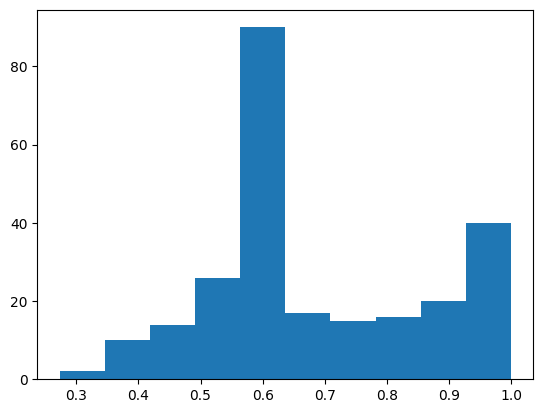

In [96]:
plt.hist(prop_max) 

In [97]:
np.where(prop_max>0.9)[0].shape

(47,)

In [98]:
prop_max.shape

(250,)

In [99]:
prop_max[np.where(prop_max>0.9)[0]].shape

(47,)